### FUNCTIONS / LIBRARIES

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
# Functions Optmization

from Optimization import prepare_vehicles_with_stats
from Optimization import spatial_optimization_pipeline
from Optimization import temporal_optimization_pipeline
from Optimization import run_fairness_pipeline
from Optimization import run_max_coverage_pipeline
from Optimization import combine_optimized_dfs
from Optimization import compute_combined_optimization_scores
from Optimization import select_random_vehicles
from Optimization import vehicle_optimization_stats_pipeline
from Optimization import extract_string_lists # Done (call if needed)
from Optimization import plot_vehicles_by_group # Done (call if needed)
from Optimization import prepare_selected_vehicles_from_combined 
from Optimization import master_function_analysis
from Optimization import visualization_master_function
from Optimization import pipeline_plot_frequency

import warnings
import geopandas as gpd
import pandas as pd

In [3]:
# Set the warning filter to ignore SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)


### RAW DATA / PARAMETERS 

In [4]:
# Full CBS
cbs_full = gpd.read_file('data/temp/full_cbs.gpkg')

# CIty Stats

city_stats = pd.read_csv('data/city_stats_amsterdam.csv')

# Gruped by points 
points_gdf = gpd.read_file('data/temp/grouped_by_points_GVB.gpkg')

# Parameters
City = 'Amsterdam'

# City Boundary 
city_geo = gpd.read_file("data/Gemeente2.geojson")

### PROCESS

In [5]:
# Usage Create Vehicles with Stats
vehicles_stats = prepare_vehicles_with_stats(points_gdf, cbs_full)

In [6]:
# Export Vehicle Stats
# vehicles_stats.to_file('data/temp/vehicles_stats_AMS_50buffer_1503.gpkg', driver='GPKG')

In [7]:
# Selecte Vehicles for Spatial Optimization
optimized_spatial, filtered_vehicles, max_space_vehicles = spatial_optimization_pipeline(points_gdf, cbs_full, vehicles_stats, coverage_threshold=3, top_n=10)

In [8]:
# Select Vehicles for temporal optimization
optimized_temporal, filtered_vehicles_temp, max_temp_vehicles = temporal_optimization_pipeline(vehicles_stats, top_n=10)

In [9]:
# Selecte Vehicles for Fairness Optimization
closest_simple, closest_relative, closest_absolute, df_area_stats, df_opts, fair_vehicles = run_fairness_pipeline(vehicles_stats, city_stats, n=10)

In [10]:
# Selecte Vehicles for Max Coverage Optimization

tops, cbs_lists, max_number, gdf_filtered, max_pop_vehicles = run_max_coverage_pipeline(vehicles_stats, cbs_full, n=10)

max_A_inhab       = tops['max_A_inhab']
max_A_old         = tops['max_A_65+']
max_A_young       = tops['max_A_0_15']
max_A_dutch       = tops['max_A_nederlan']
max_A_non_western = tops['max_A_n_west_m']
max_P_old         = tops['max_P_65+']
max_P_non_western = tops['max_P_n_west_m']
max_point_count   = tops['max_count']

In [11]:
max_space_vehicles

,max_spatial
0,1921_GVB
1,309_GVB
2,2268_GVB
3,2021_GVB
4,1467_GVB
5,1105_GVB
6,310_GVB
7,2125_GVB
8,1408_GVB
9,2096_GVB


In [12]:
# Create Combined First Itearation 
combined_df = combine_optimized_dfs(max_space_vehicles, max_temp_vehicles, max_pop_vehicles, fair_vehicles)

In [13]:
# Combined vehicles (based on chosen columns) - not included | May go for discussion in the paper
scores_combined_df, top_combined_final = compute_combined_optimization_scores(combined_df)

In [14]:
# Create Random Vehicles 
random_vehicles = select_random_vehicles(vehicles_stats, n=10) 

In [15]:
print(combined_df.columns.tolist())


['max_spatial', 'max_temporal', 'max_A_inhab', 'max_A_65+', 'max_A_0_15', 'max_A_nederlan', 'max_A_n_west_m', 'max_P_65+', 'max_P_n_west_m', 'max_count', 'closest_absolute', 'closest_relative', 'closest_simple']


In [16]:
# 1) build all_vehicles from gdf_vehicles, not vehicles_stats
all_vehicles = pd.DataFrame({
    'all_vehicles': vehicles_stats['uni_id'].astype(str)
})

# 2) reset its index to 0…177
all_vehicles = all_vehicles.reset_index(drop=True)

In [17]:
# Take random 10 vehicles from the combined DataFrame
#all_vehicles = all_vehicles.sample(n=50, random_state=1)


In [18]:
# Create Selected Vehicles Stats
final_df_cells_test = vehicle_optimization_stats_pipeline(
    vehicles_stats,
    cbs_full,
    city_stats,
    max_space_vehicles,
    max_temp_vehicles,
    max_pop_vehicles,
    fair_vehicles,
    top_combined_final, # as these are not included in the final analysis
    random_vehicles,
    all_vehicles
)

In [19]:

# Globally format all floats as integers with thousands separators
pd.set_option('display.float_format', '{:,.0f}'.format)

In [20]:
# We have tiny error that Amsterdam is not showing the right value 
final_df_cells_test.at['cells_unique', 'Amsterdam'] = len(cbs_full)
# We have tiny error that Amsterdam is not showing the right value 
final_df_cells_test.at['avg_points_per_cell', 'Amsterdam'] = '-'

In [21]:
# TWO VARIANTS for TEMPORAL - starting from max point vehicles - more points - or starting from max avg_points_per_cell - maybe better for the graph
final_df_cells_test

,max_spatial,max_temporal,max_A_inhab,max_A_65+,max_A_0_15,max_A_nederlan,max_A_n_west_m,max_P_65+,max_P_n_west_m,max_count,fairest_absolute,fairest_relative,fairest_simple,combined_opt,random,all_vehicles,Amsterdam
A_inhab,"587,505","252,970","877,585","861,560","849,125","874,315","853,180","172,690","162,365","282,840","331,010","331,870","330,255","528,490","354,560","8,471,845",-
A_0_15,"71,715","35,672","108,240","106,600","110,172","107,637","107,160","25,197","23,952","31,532","35,068","39,775","34,984","63,895","43,821","1,050,147",-
A_65+,"72,863","36,914","104,777","106,683","98,762","106,656","99,245","30,652","20,429","36,727","39,983","40,844","39,888","66,342","43,341","1,047,752",-
A_nederlan,"261,317","103,585","369,458","372,323","355,076","375,432","348,964","93,171","36,418","129,057","148,290","141,403","147,913","231,411","154,273","3,656,741",-
A_n_west_m,"199,562","110,423","324,815","308,370","324,427","315,273","330,549","49,174","106,755","91,139","107,371","119,512","107,186","182,353","127,267","3,006,099",-
count,"95,856","93,154","82,135","80,766","82,562","79,197","81,200","98,505","52,062","137,532","102,564","91,836","104,212","104,689","81,902","2,127,870",-
A_inhab_uniq,"354,185","56,930","256,155","272,150","255,155","257,180","230,950","44,055","28,735","167,980","116,185","198,835","116,185","288,955","231,420","403,240","870,375"
A_0_15_uniq,"45,384","8,550","33,177","35,750","34,090","33,023","29,573","5,855","4,122","19,886","13,378","24,960","13,378","37,180","28,900","52,298",122388
A_65+_uniq,"44,718","8,517","32,140","34,365","31,496","32,460","28,481","7,898","3,775","21,616","14,898","24,455","14,898","36,355","27,877","51,191",112084
A_nederlan_uniq,"158,150","26,098","107,268","116,027","107,731","109,405","95,536","22,879","7,066","75,604","49,270","82,951","49,270","125,221","103,501","178,541",382106


### THIS IS WHERE WE MAKE RANDOM VEHICLES AND ALL STATS

In [22]:
random_df = pd.DataFrame()

for i in range(20):
    # 1. Generate new random vehicles
    random_vehicles = select_random_vehicles(vehicles_stats, n=6, seed=i)

    # 2. Run the pipeline
    final_df = vehicle_optimization_stats_pipeline(
        vehicles_stats,
        cbs_full,
        city_stats,
        max_space_vehicles,
        max_temp_vehicles,
        max_pop_vehicles,
        fair_vehicles,
        top_combined_final,
        random_vehicles,
        all_vehicles
    )

   # 3. Get just the random column
    col_name = f"random_{i+1}"
    col = final_df[["random"]].rename(columns={"random": col_name})

    # 4. Append to master DataFrame
    if random_df.empty:
        random_df = col
    else:
        random_df[col_name] = col[col_name]


In [41]:
# add all_vehicles	Amsterdam from final_df_cells_test
random_df["all_vehicles"] = final_df_cells_test["all_vehicles"]
random_df["Amsterdam"] = final_df_cells_test["Amsterdam"]

random_df

,random_1,random_2,random_3,random_4,random_5,random_6,random_7,random_8,random_9,random_10,...,random_13,random_14,random_15,random_16,random_17,random_18,random_19,random_20,all_vehicles,Amsterdam
indicator,,,,,,,,,,,,,,,,,,,,,
A_inhab,"180,070","197,970","267,175","199,900","159,635","163,950","236,195","157,450","211,075","147,070",...,"251,425","131,760","215,025","175,055","108,910","268,845","173,215","258,390","8,471,845",-
A_0_15,"21,732","23,966","32,015","23,063","18,526","19,722","28,767","19,512","25,007","18,747",...,"32,795","14,922","29,575","22,009","12,965","33,562","19,851","30,769","1,050,147",-
A_65+,"23,705","22,187","31,560","26,161","19,285","20,951","29,696","19,028","25,306","20,557",...,"26,883","15,934","27,251","21,542","14,195","32,016","22,203","33,591","1,047,752",-
A_nederlan,"66,603","85,384","107,494","92,507","69,638","76,213","95,027","60,750","96,757","63,650",...,"101,531","57,267","95,044","79,701","51,909","107,080","76,042","113,217","3,656,741",-
A_n_west_m,"76,680","69,326","105,072","61,295","55,331","48,933","88,830","65,273","66,858","52,133",...,"100,317","45,190","79,315","56,183","33,207","105,482","59,107","87,997","3,006,099",-
count,"41,801","50,001","49,830","54,087","52,233","49,062","44,160","42,030","50,799","53,892",...,"46,059","41,896","55,431","46,552","38,776","30,006","59,711","48,764","2,127,870",-
A_inhab_uniq,"119,810","162,325","193,700","115,525","130,430","116,795","165,140","133,665","173,735","130,915",...,"143,385","112,965","181,615","156,760","102,390","196,425","96,840","164,435","403,240","870,375"
A_0_15_uniq,"13,980","20,231","23,833","13,373","15,526","14,946","20,515","16,814","21,135","16,816",...,"18,229","12,827","24,865","20,210","12,118","24,617","11,690","19,832","52,298",122388
A_65+_uniq,"16,159","18,117","22,945","15,182","15,614","14,737","20,941","16,382","20,804","18,025",...,"16,014","13,756","22,647","19,376","13,465","24,419","12,505","21,635","51,191",112084


In [42]:
random_df.index.name = "indicator"
random_df.to_csv('data/temp/random_vehicles_N6_S20_test.csv', index=True, index_label=False)

In [44]:
pd.read_csv('data/temp/random_vehicles_N6_S20_test.csv')

,random_1,random_2,random_3,random_4,random_5,random_6,random_7,random_8,random_9,random_10,...,random_13,random_14,random_15,random_16,random_17,random_18,random_19,random_20,all_vehicles,Amsterdam
A_inhab,"180,070","197,970","267,175","199,900","159,635","163,950","236,195","157,450","211,075","147,070",...,"251,425","131,760","215,025","175,055","108,910","268,845","173,215","258,390","8,471,845",-
A_0_15,"21,732","23,966","32,015","23,063","18,526","19,722","28,767","19,512","25,007","18,747",...,"32,795","14,922","29,575","22,009","12,965","33,562","19,851","30,769","1,050,147",-
A_65+,"23,705","22,187","31,560","26,161","19,285","20,951","29,696","19,028","25,306","20,557",...,"26,883","15,934","27,251","21,542","14,195","32,016","22,203","33,591","1,047,752",-
A_nederlan,"66,603","85,384","107,494","92,507","69,638","76,213","95,027","60,750","96,757","63,650",...,"101,531","57,267","95,044","79,701","51,909","107,080","76,042","113,217","3,656,741",-
A_n_west_m,"76,680","69,326","105,072","61,295","55,331","48,933","88,830","65,273","66,858","52,133",...,"100,317","45,190","79,315","56,183","33,207","105,482","59,107","87,997","3,006,099",-
count,"41,801","50,001","49,830","54,087","52,233","49,062","44,160","42,030","50,799","53,892",...,"46,059","41,896","55,431","46,552","38,776","30,006","59,711","48,764","2,127,870",-
A_inhab_uniq,"119,810","162,325","193,700","115,525","130,430","116,795","165,140","133,665","173,735","130,915",...,"143,385","112,965","181,615","156,760","102,390","196,425","96,840","164,435","403,240",870375.0
A_0_15_uniq,"13,980","20,231","23,833","13,373","15,526","14,946","20,515","16,814","21,135","16,816",...,"18,229","12,827","24,865","20,210","12,118","24,617","11,690","19,832","52,298",122388
A_65+_uniq,"16,159","18,117","22,945","15,182","15,614","14,737","20,941","16,382","20,804","18,025",...,"16,014","13,756","22,647","19,376","13,465","24,419","12,505","21,635","51,191",112084
A_nederlan_uniq,"49,546","68,508","78,062","54,488","57,080","52,677","66,317","53,519","78,808","55,567",...,"59,703","49,389","81,146","70,322","49,462","80,865","41,961","70,745","178,541",382106


In [24]:
# THEN GO SEE THE TASKS TO DO FRO EXPORRTS
# GITHUB REPO Update + Share 
# TITUS | 

In [25]:
# Createa CSV with the selected vehicles
# combined_df.to_csv('data/temp/combined_df_10_AMS_1503.csv', index=False)

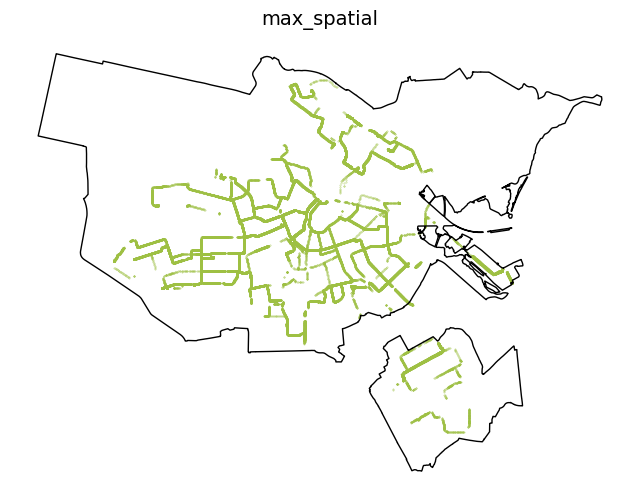

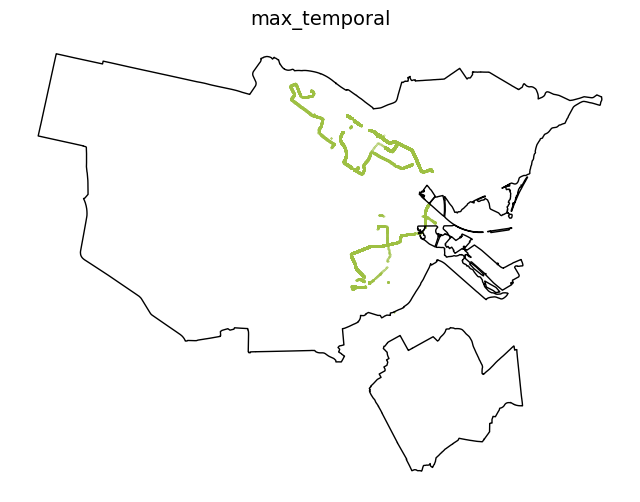

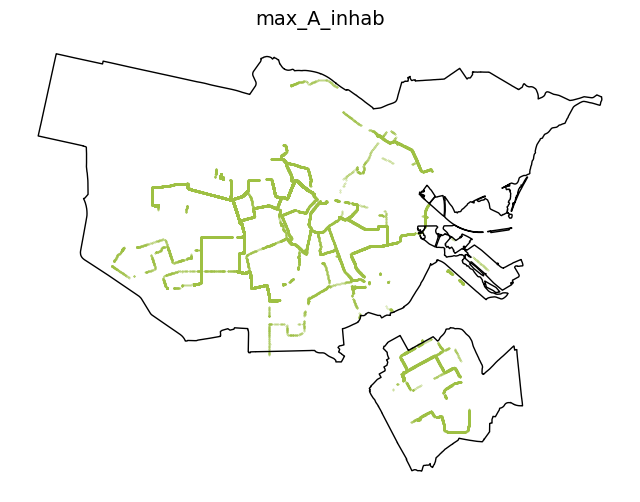

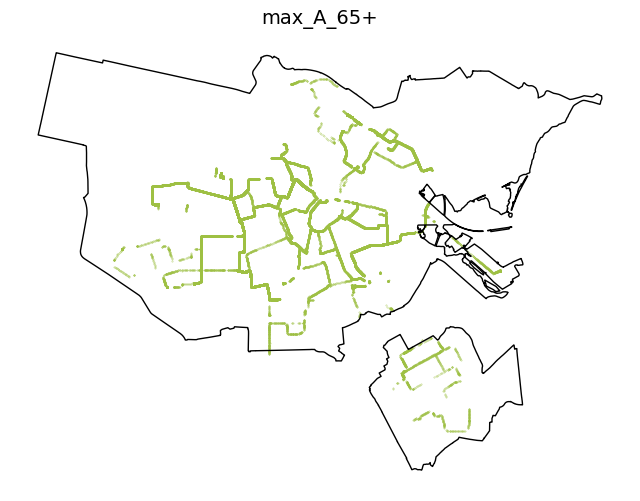

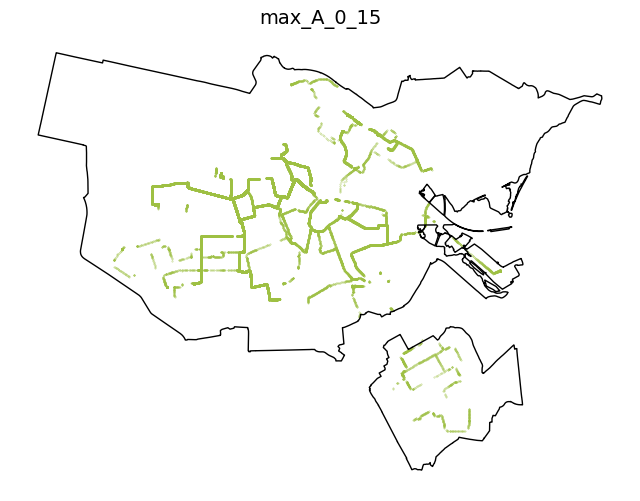

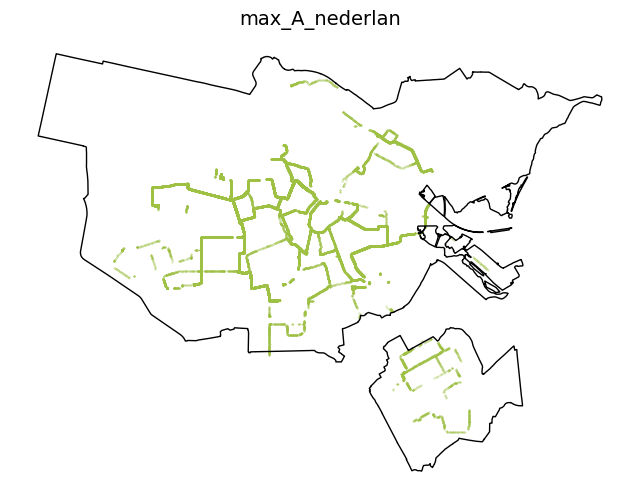

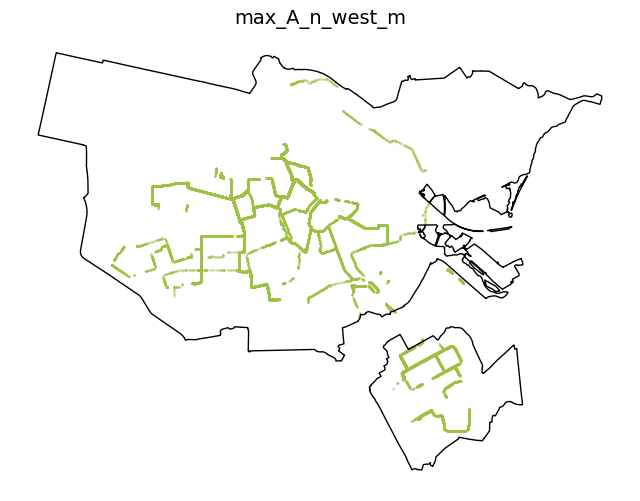

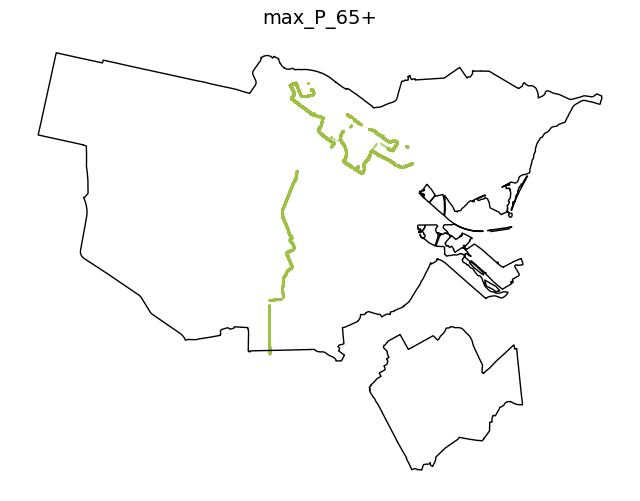

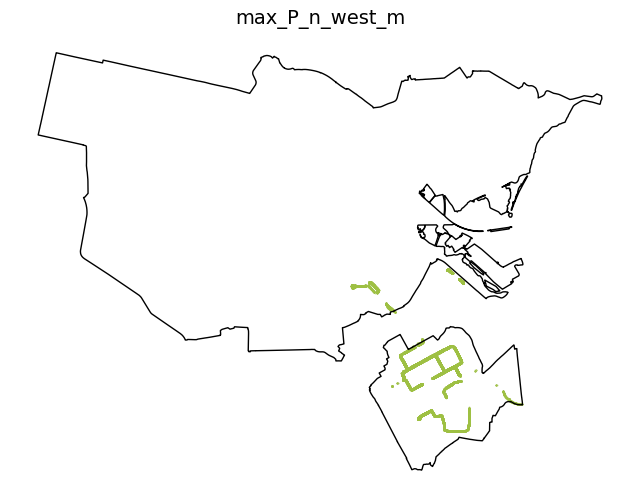

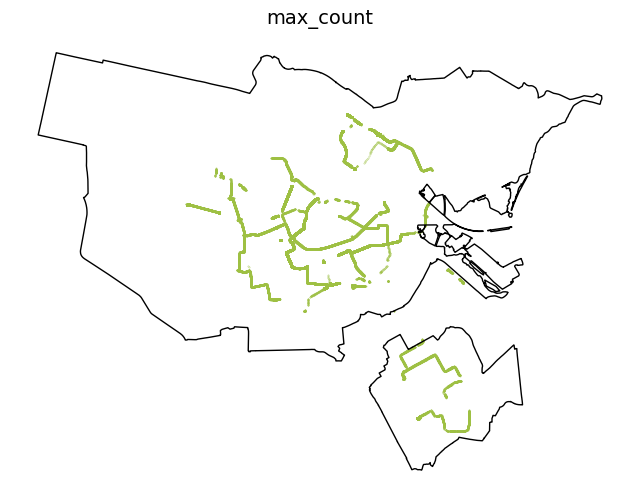

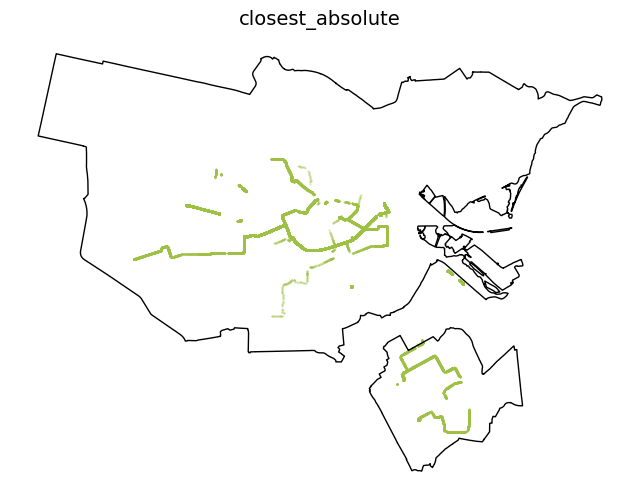

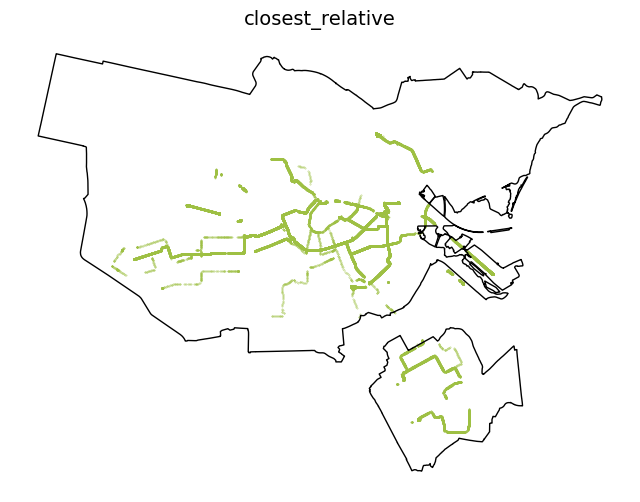

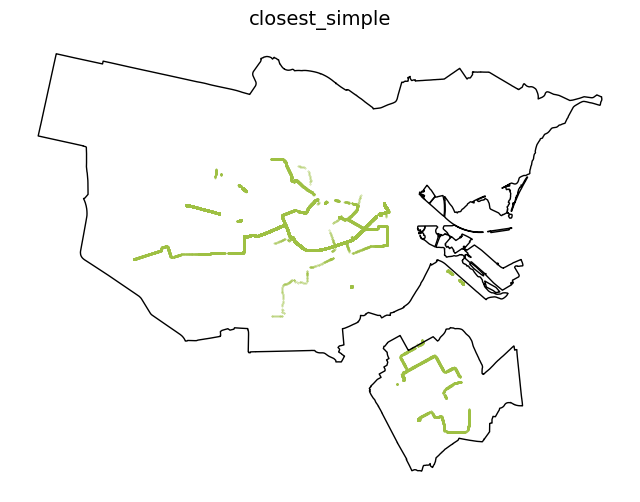

In [26]:
# Usage Visualization Quick (Only if needed!)

lists_dict = extract_string_lists(combined_df)
lists_dict.keys()
plot_vehicles_by_group(vehicles_stats, lists_dict, city_geo) 

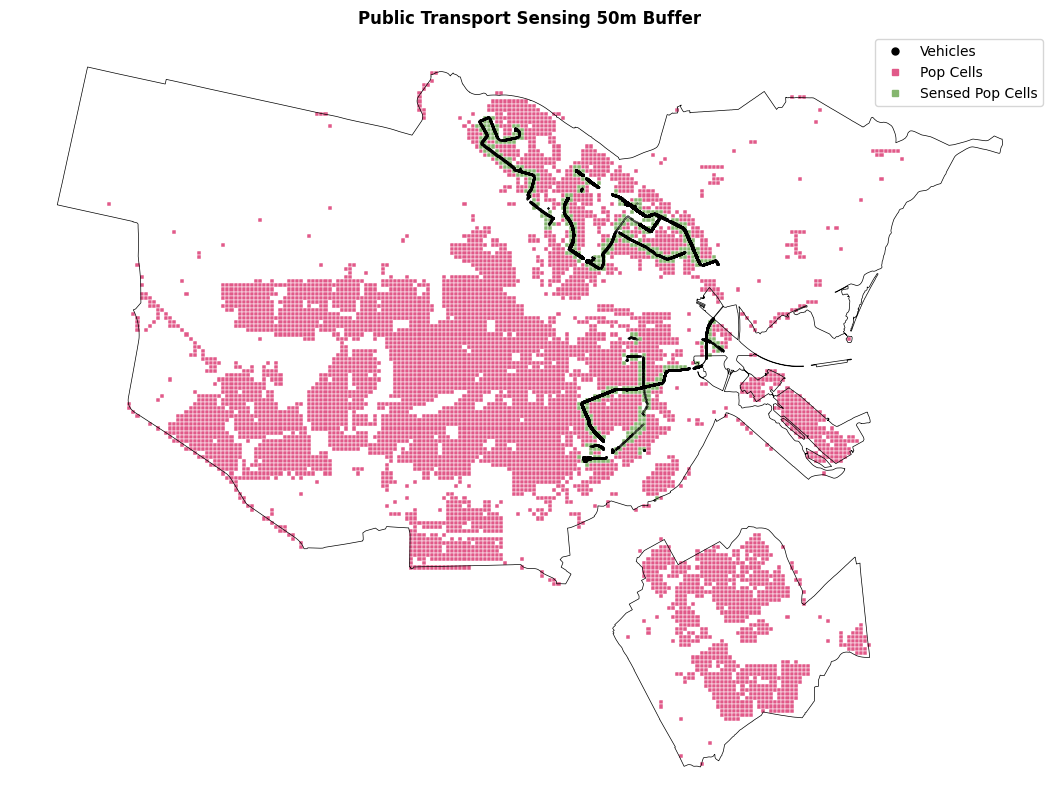

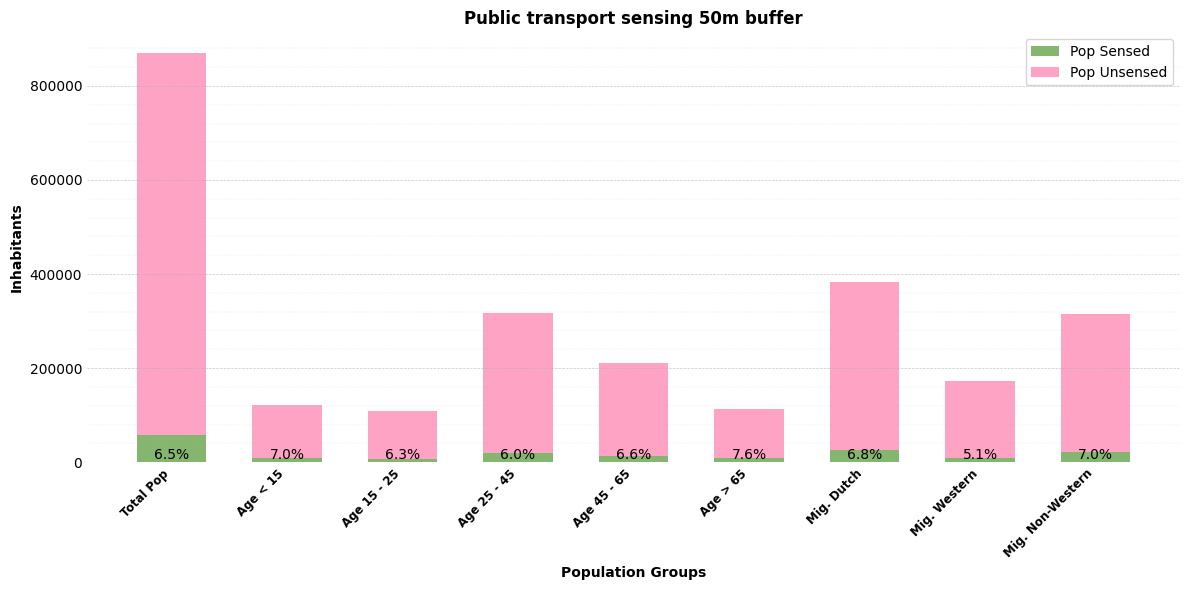

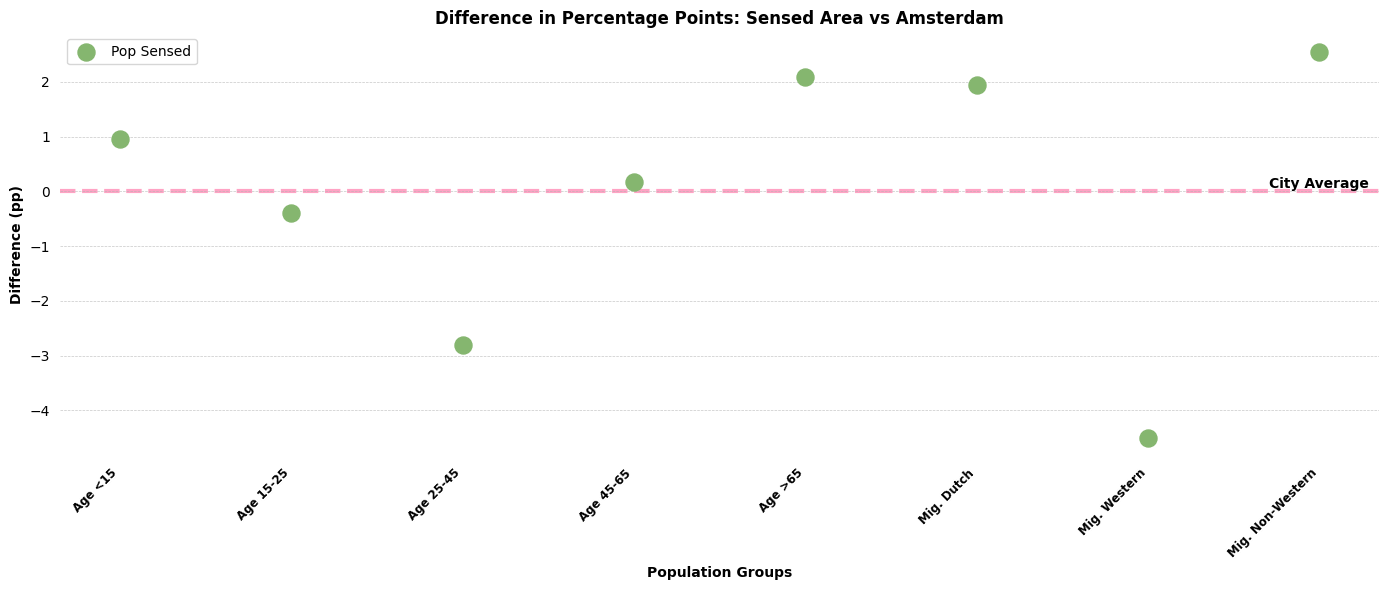

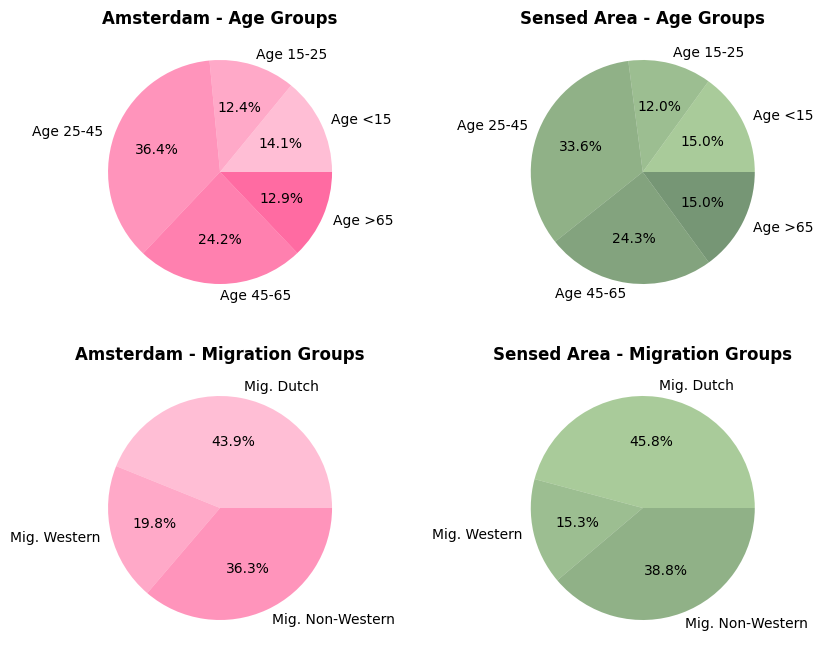

In [25]:
# Create Optmized Vehicles GDFs 
max_space_gdf = prepare_selected_vehicles_from_combined(vehicles_stats, combined_df, column='max_temporal')
# Create Main Analysis 
sums_df, cbs_gdf, joined_gdf, average_stats = master_function_analysis(
    max_space_gdf, cbs_full,50)
# Create Main Visualization 
fig1, fig2, fig3, fig4 = visualization_master_function(
    max_space_gdf, cbs_full, joined_gdf, city_geo, 50, sums_df, average_stats)